In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import json
import os

from supabase import create_client, Client
from dotenv import load_dotenv
import sys
# !{sys.executable} -m pip install -r requirements.txt

load_dotenv()

url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [13]:
# Fetch data from Supabase
response = supabase.table("color_test_results").select("*").execute()

# Check the response
# print(f"Number of rows retrieved: {len(response.data)}")
# print("First row:")
# print(json.dumps(response.data[0], indent=2))

In [14]:
import pandas as pd

# Create DataFrame
df = pd.DataFrame(response.data)

# Check DataFrame info
# print(df.info())

# # Display the first few rows
# print(df.head())

# # Check the 'final_hues' column
# print(df['final_hues'].head())

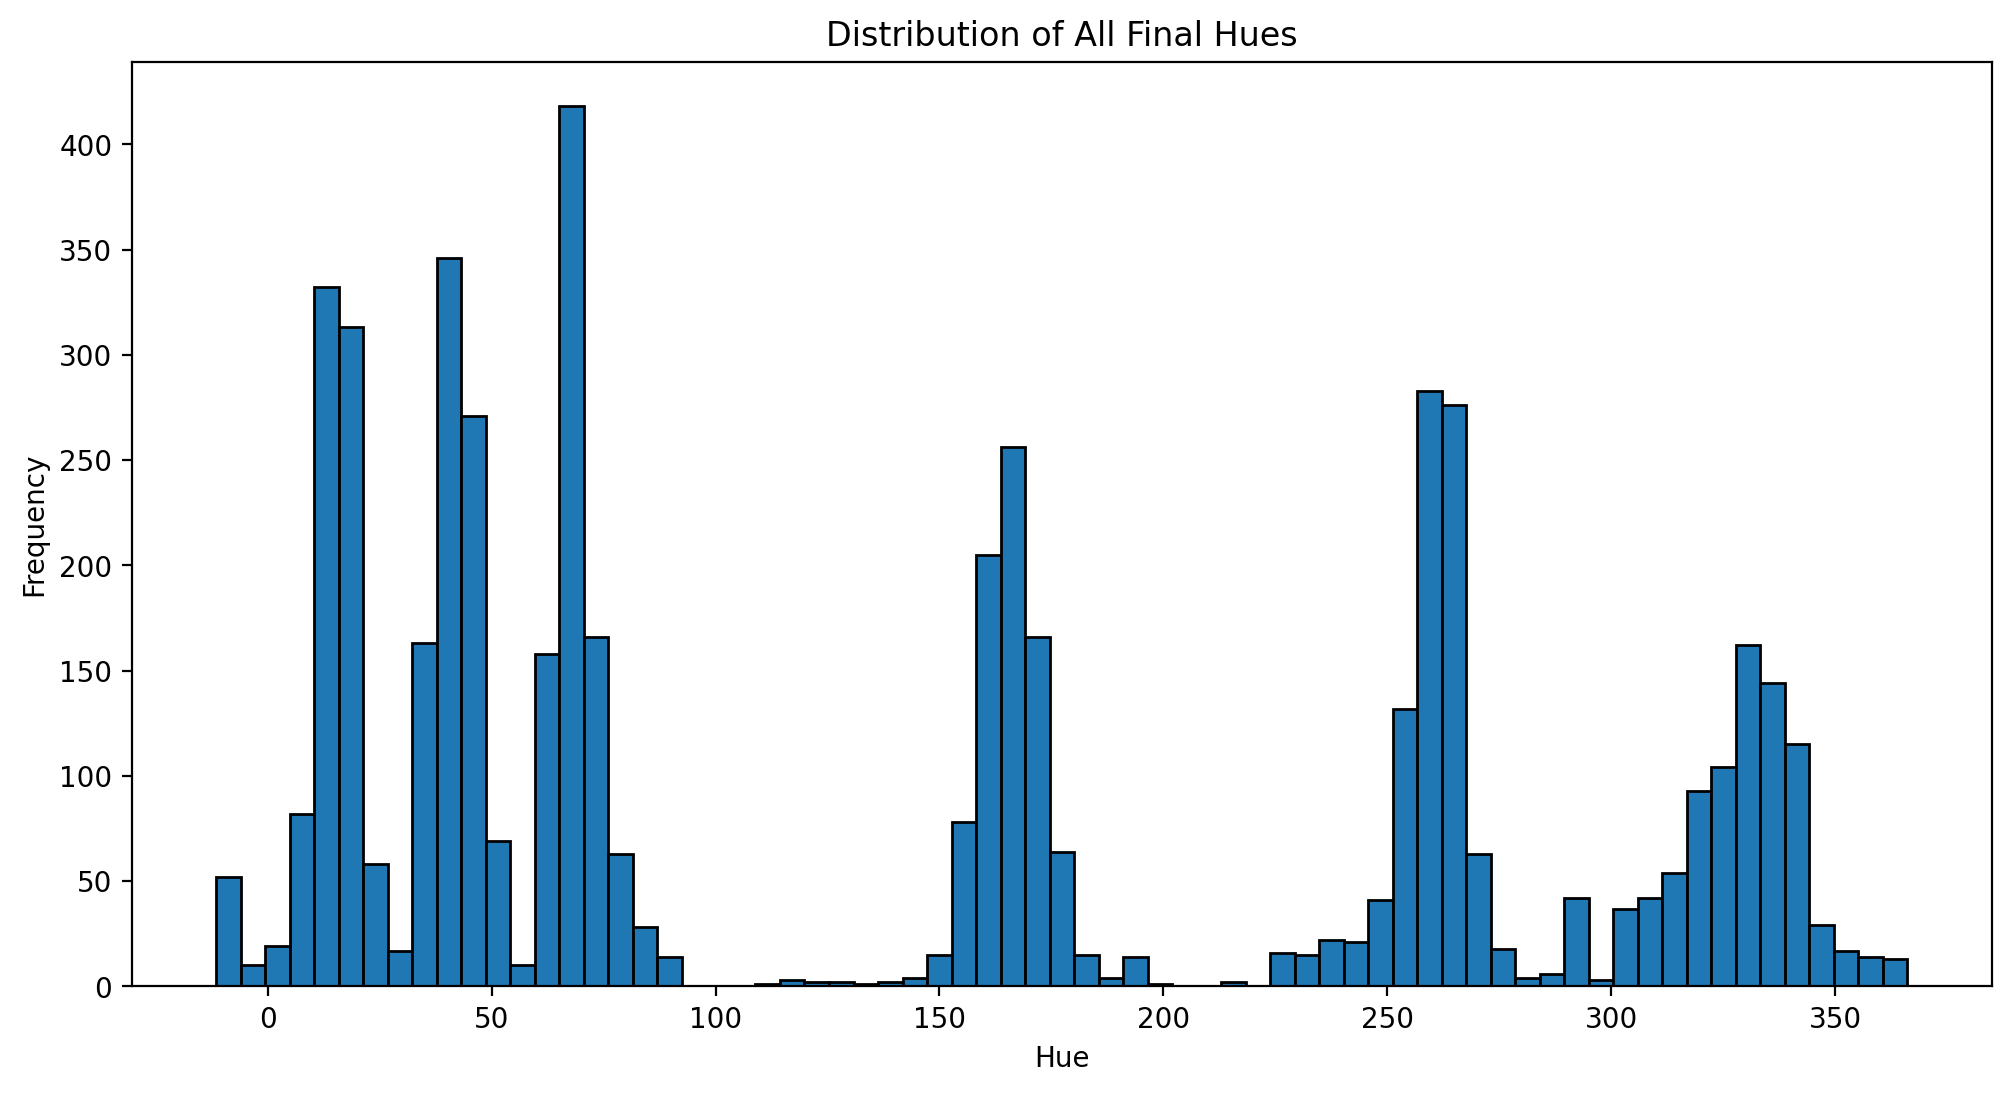

In [15]:
# Explode the final_hues column so each hue gets its own row
df_exploded = df.explode('final_hues')

# Check the result
# print("\nFirst few rows of exploded DataFrame:")
# print(df_exploded[['id', 'final_hues']].head(10))

# # Get some basic statistics
# print("\nBasic statistics of 'final_hues':")
# print(df_exploded['final_hues'].describe())

# Create a histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(df_exploded['final_hues'], bins=69, edgecolor='black')
plt.title('Distribution of All Final Hues')
plt.xlabel('Hue')
plt.ylabel('Frequency')
plt.show()

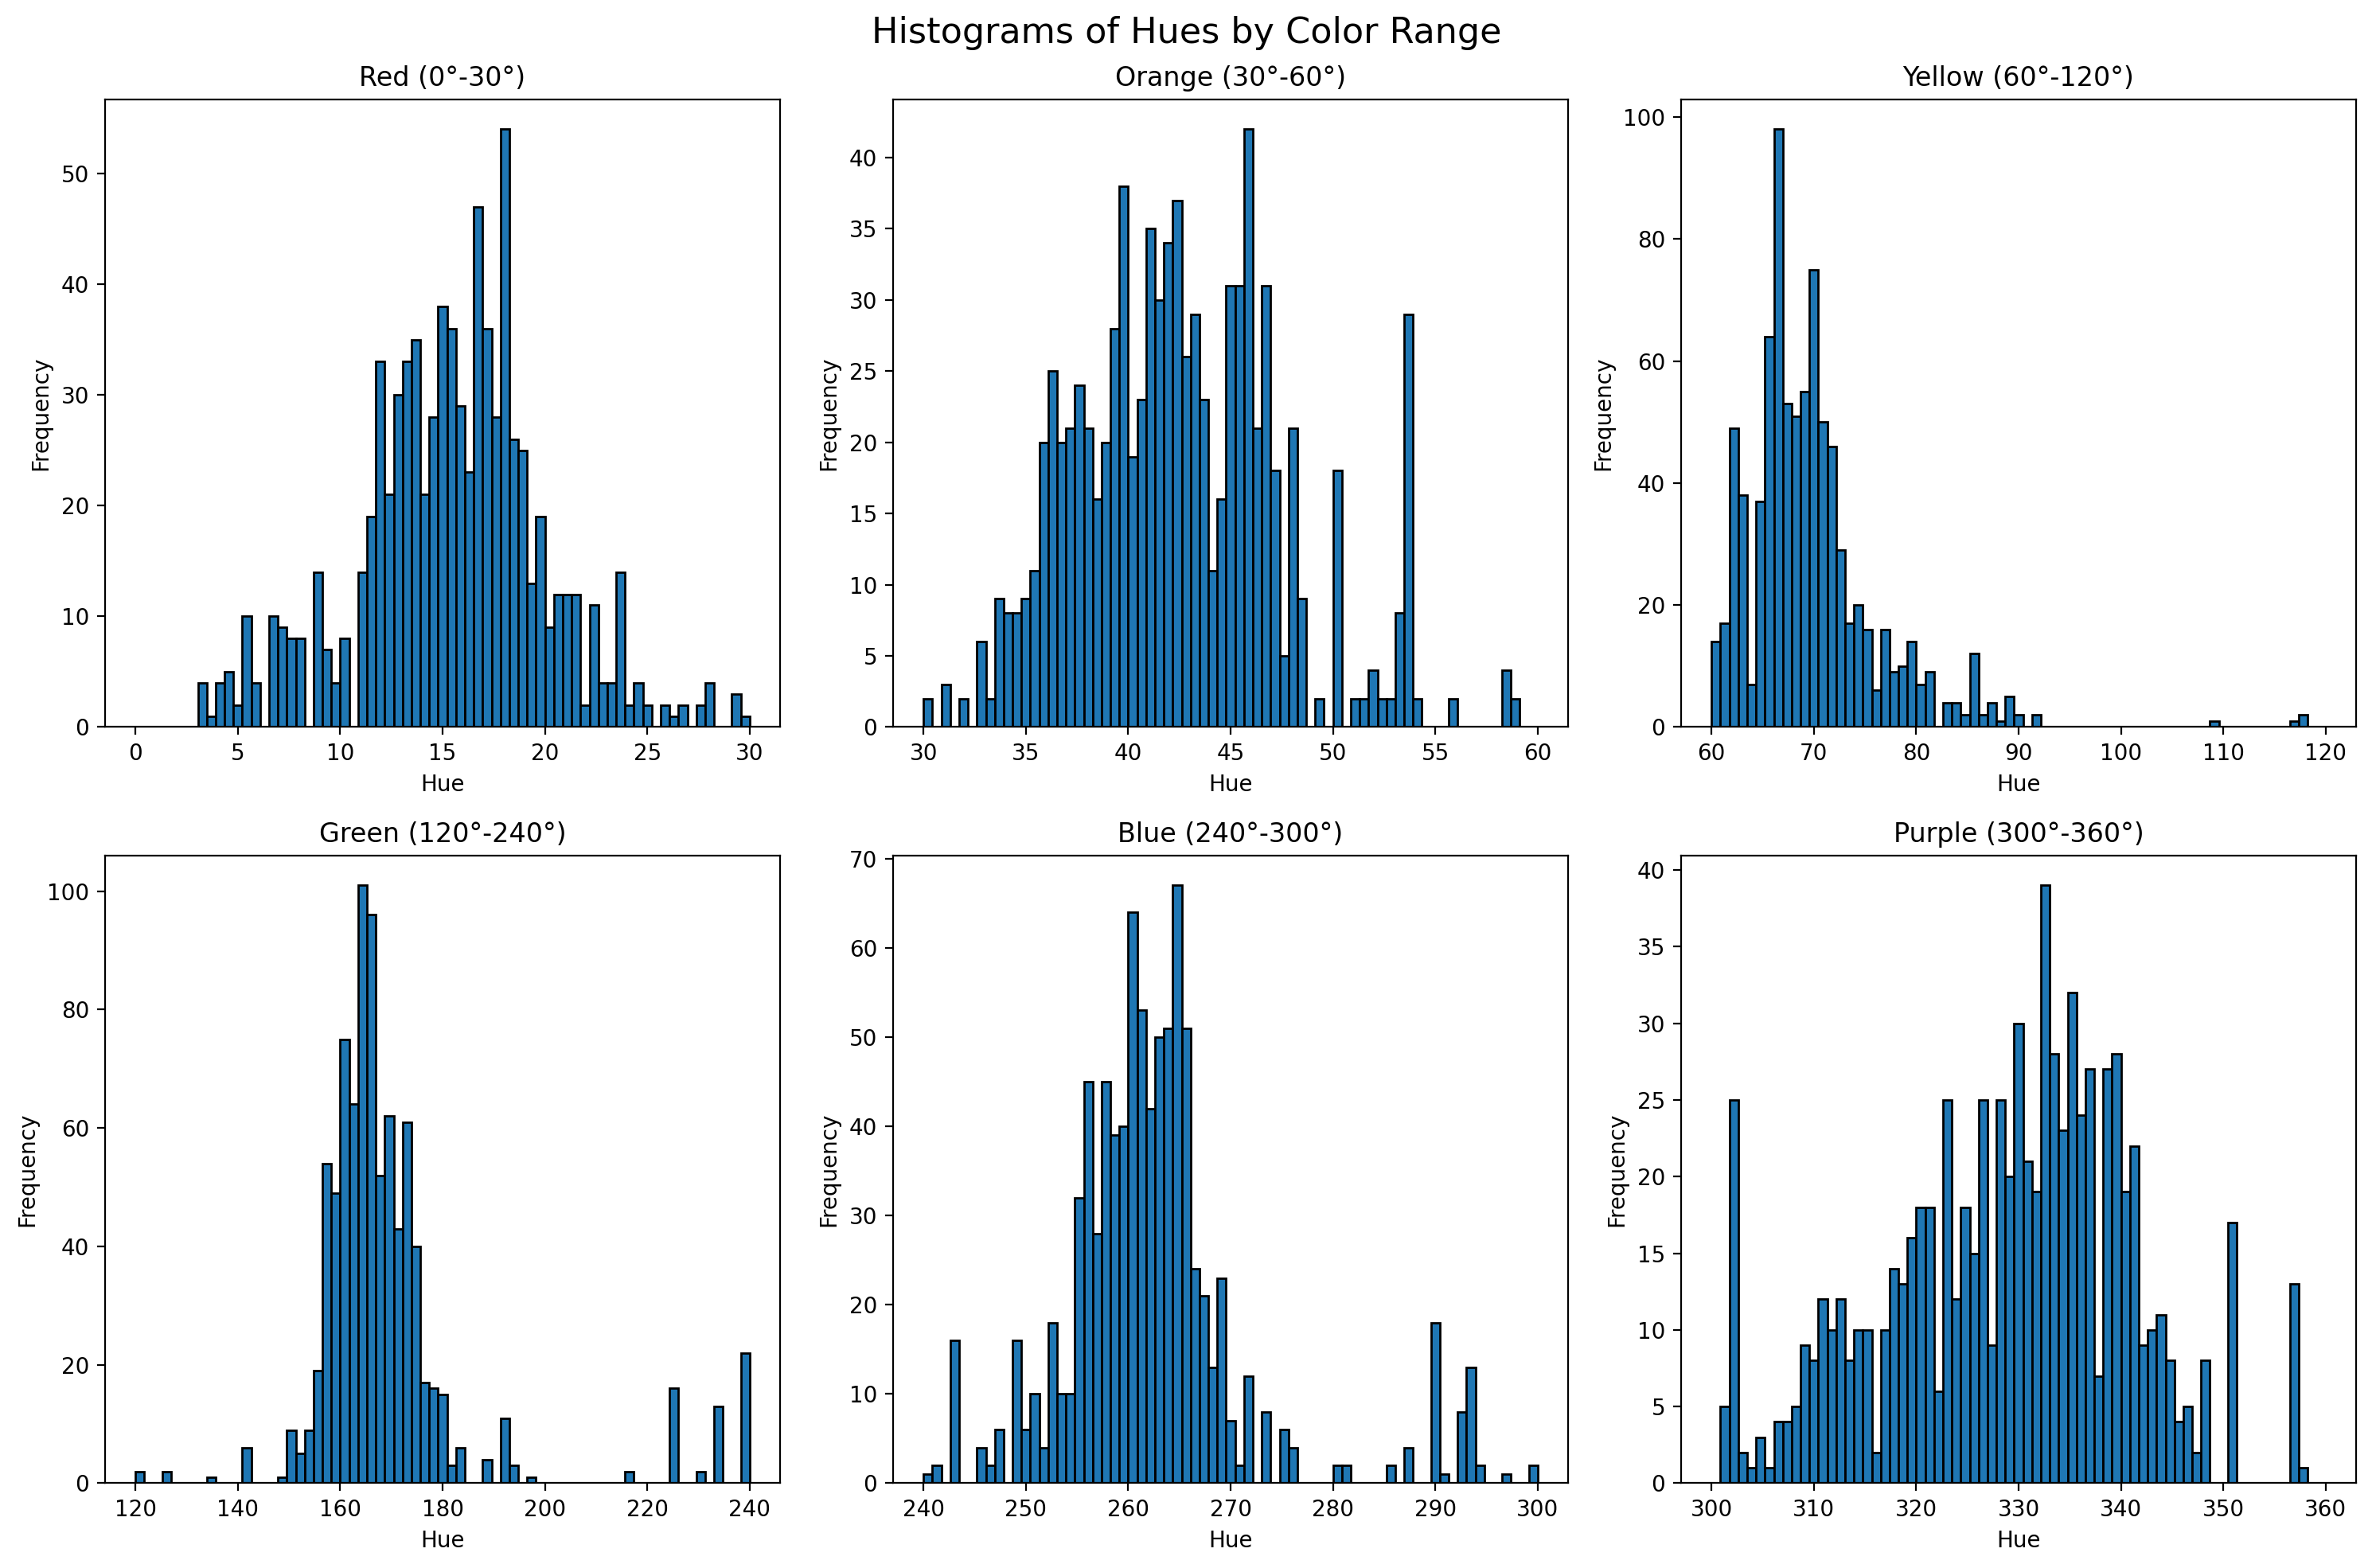

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_boundaries(df):
    xy = df.final_hue.value_counts().sort_index().reset_index()
    final_hue_raw = xy["final_hue"].values
    raw_count = xy["count"].values
    raw_count = raw_count / raw_count.sum()

    count = np.cumsum(raw_count) / raw_count.sum()
    count = np.stack((np.concatenate(([0.0], count[:-1])), count), axis=1)
    final_hue = np.stack((final_hue_raw, final_hue_raw), axis=1)

    count = count.ravel()
    final_hue = final_hue.ravel()

    return final_hue_raw, raw_count, final_hue, count

# Define color ranges
color_ranges = [
    ("Red", (0, 30)),
    ("Orange", (30, 60)),
    ("Yellow", (60, 120)),
    ("Green", (120, 240)),
    ("Blue", (240, 300)),
    ("Purple", (300, 360))
]

# Create a figure with 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Histograms of Hues by Color Range', fontsize=16)

for (color, (start, end)), ax in zip(color_ranges, axs.flatten()):
    # Filter hues in the current range
    hues = [h for hues in df.final_hues for h in hues if start <= h < end]
    
    # Create histogram with 69 bins
    counts, bins, _ = ax.hist(hues, bins=69, range=(start, end), edgecolor='black')
    
    ax.set_title(f'{color} ({start}°-{end}°)')
    ax.set_xlabel('Hue')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

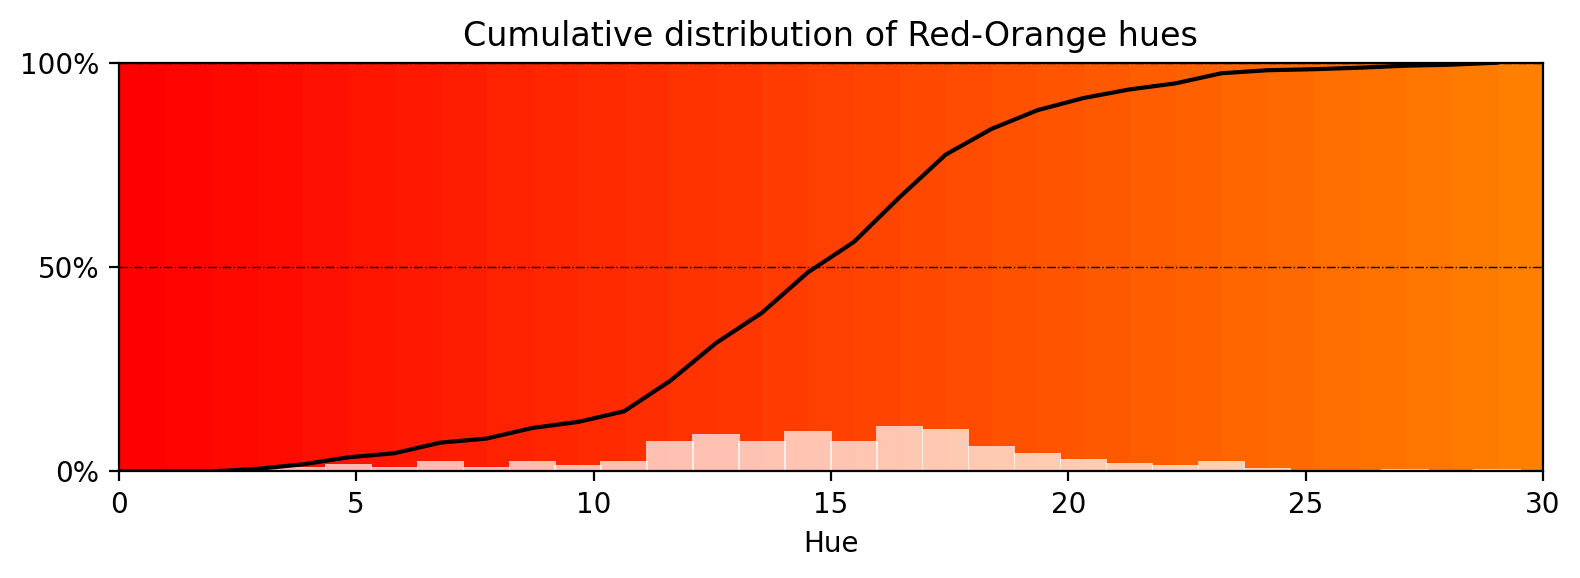

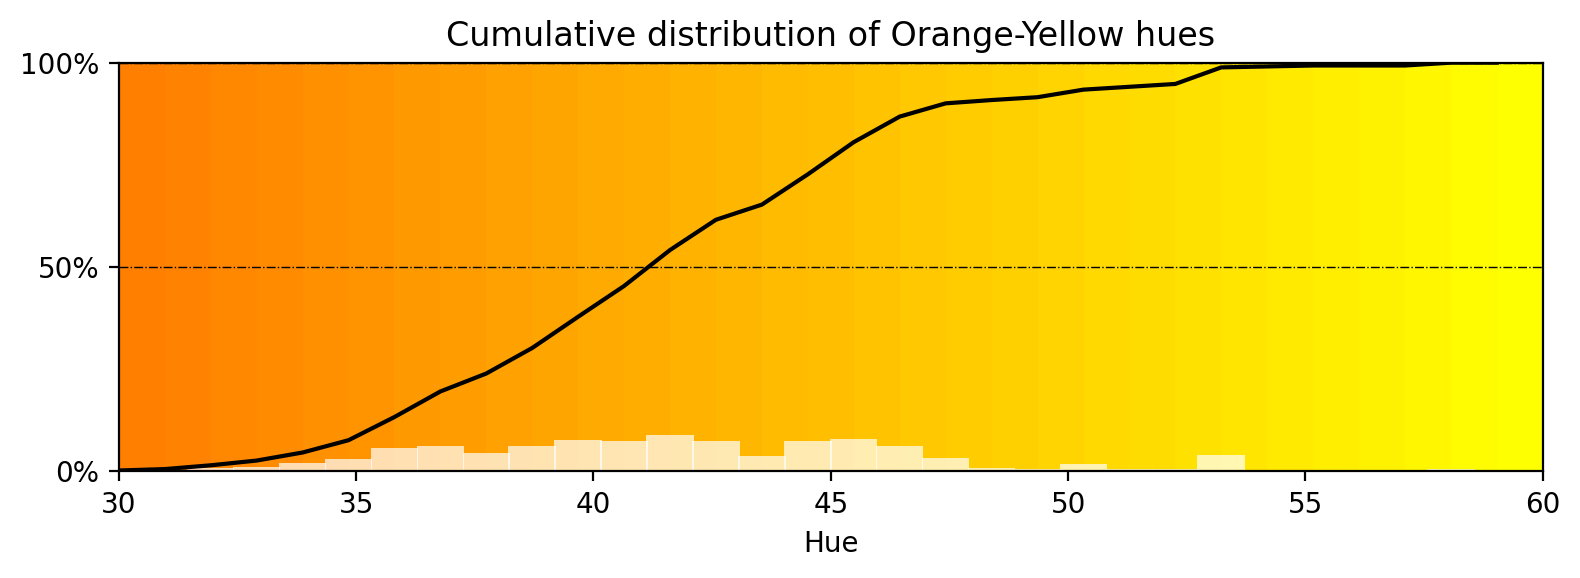

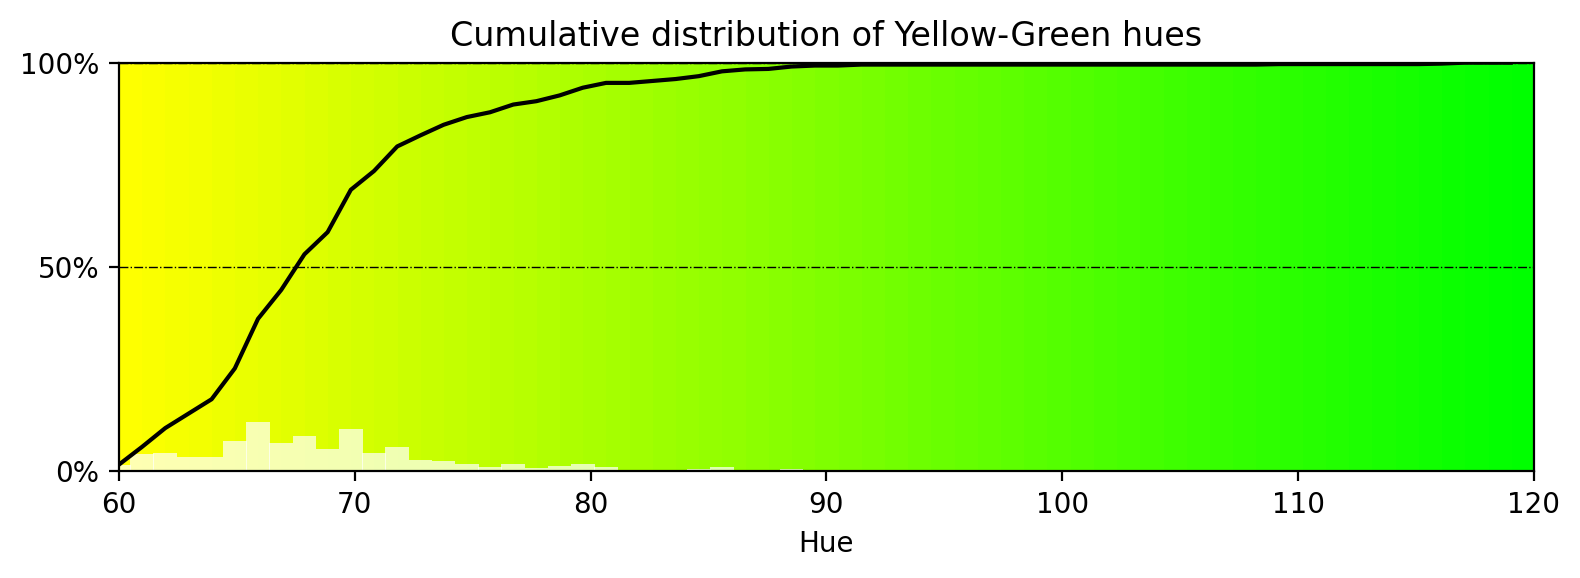

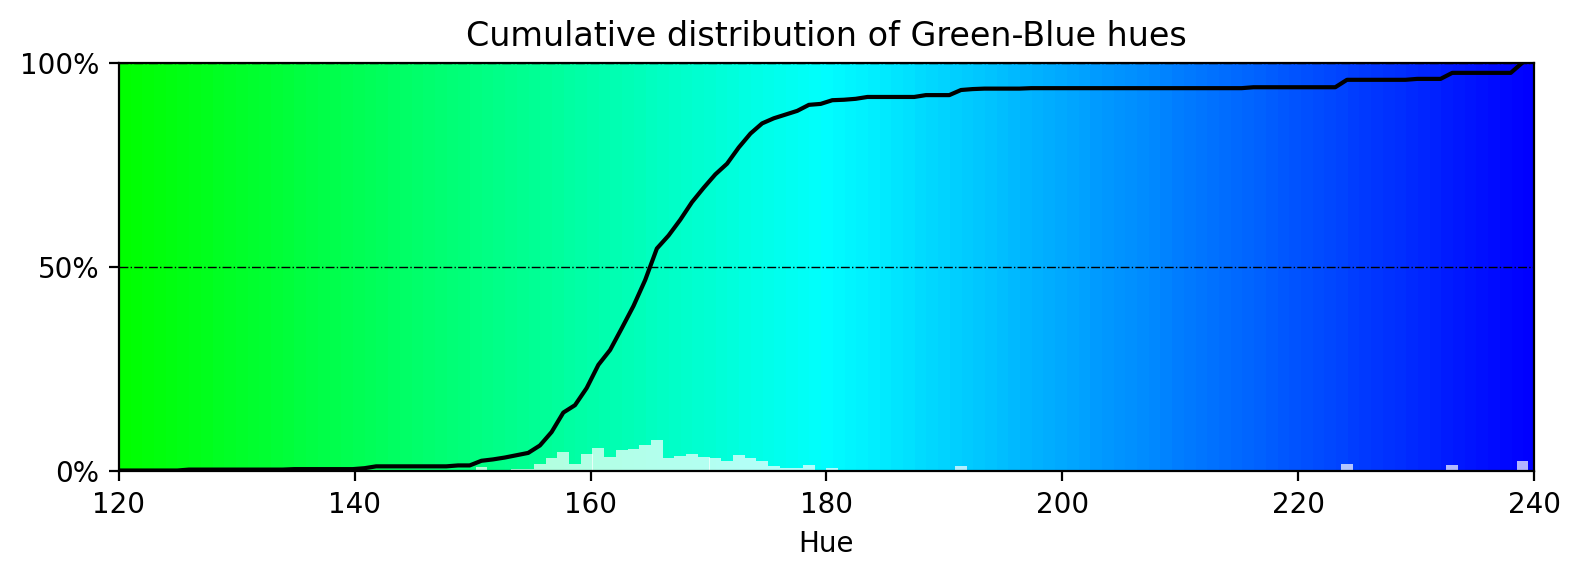

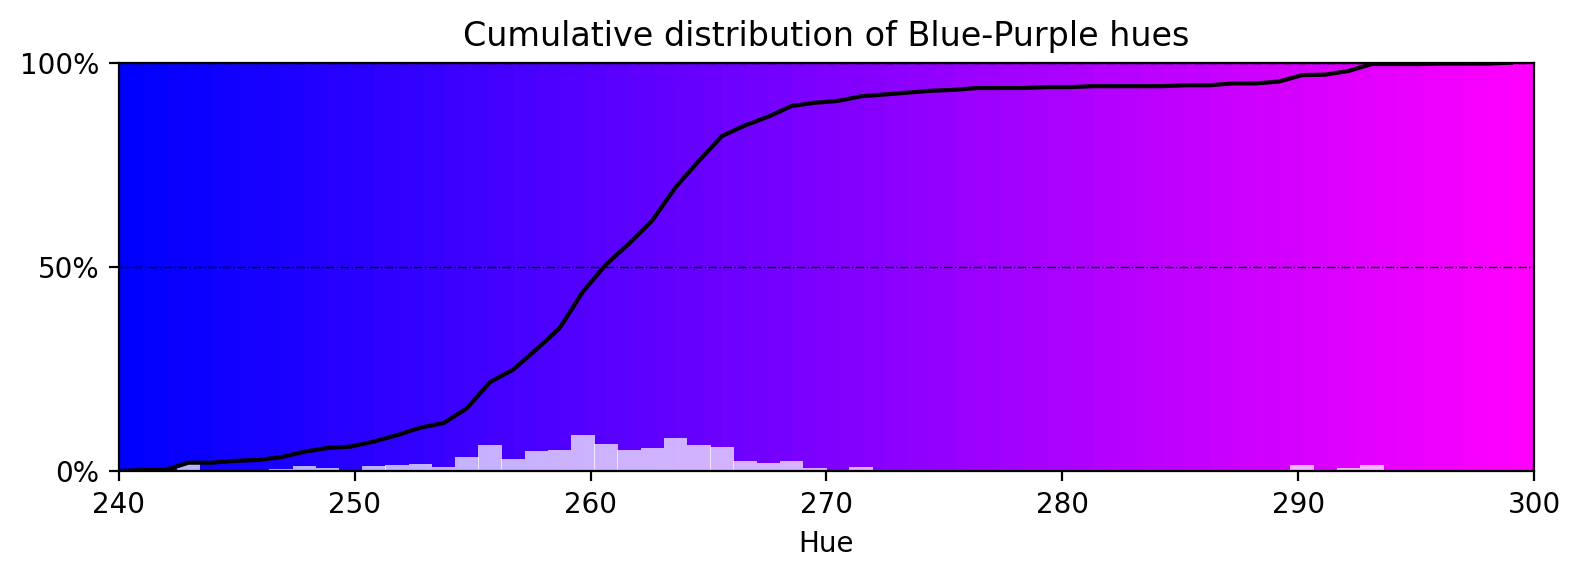

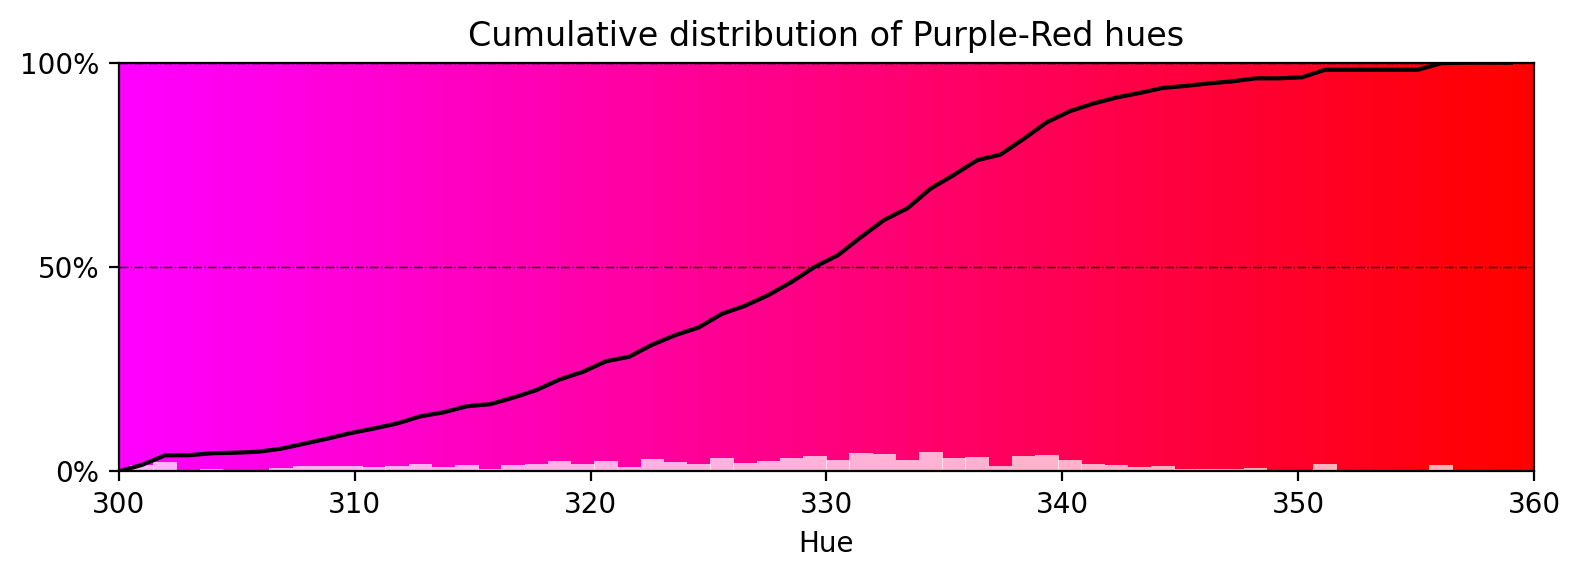

In [7]:
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from colorsys import hls_to_rgb
import matplotlib.pyplot as plt

def show_threshold(df, hue_range, title):
    all_hues = [hue for hues in df['final_hues'] for hue in hues if hue_range[0] <= hue <= hue_range[1]]
    
    data = [hls_to_rgb(i / 360, .5, 1) for i in range(hue_range[0], hue_range[1] + 1)]
    cmap = LinearSegmentedColormap.from_list("custom", data)
    
    counts, bin_edges = np.histogram(all_hues, bins=hue_range[1]-hue_range[0]+1, range=hue_range)
    cumulative = np.cumsum(counts) / len(all_hues)

    plt.figure(figsize=(8, 3))
    gradient = np.linspace(0, 1, hue_range[1]-hue_range[0]+1).reshape(1, -1)
    plt.imshow(gradient, aspect='auto', extent=[hue_range[0], hue_range[1], 0, 1], cmap=cmap)

    plt.bar(bin_edges[:-1], counts/counts.sum(), color='white', alpha=0.7, width=1)
    plt.plot(bin_edges[:-1], cumulative, '-', color='black')

    plt.xlim(hue_range)
    plt.xlabel("Hue")
    plt.yticks([0, .5, 1], ["0%", "50%", "100%"])
    plt.title(title)
    plt.grid(True, axis='y', color='black', linestyle='-.', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Color pairs and their approximate hue ranges
color_pairs = [
    ("Red-Orange", (0, 30)),
    ("Orange-Yellow", (30, 60)),
    ("Yellow-Green", (60, 120)),
    ("Green-Blue", (120, 240)),
    ("Blue-Purple", (240, 300)),
    ("Purple-Red", (300, 360))
]

# Create 6 separate graphs
for pair, hue_range in color_pairs:
    show_threshold(df, hue_range, f"Cumulative distribution of {pair} hues")

In [8]:
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from colorsys import hls_to_rgb
import matplotlib.pyplot as plt

def show_threshold(df, hue_range, color1, color2, output_file):
    # Extract hues in the current range
    all_hues = [hue for hues in df['final_hues'] for hue in hues if hue_range[0] <= hue <= hue_range[1]]

    # Calculate histogram and cumulative distribution
    counts, bin_edges = np.histogram(all_hues, bins=hue_range[1]-hue_range[0]+1, range=hue_range)
    cumulative = np.cumsum(counts) / len(all_hues)

    bin_position = bin_edges[:-1]
    count = counts / len(all_hues)
    x_cdf, y_cdf = bin_position, cumulative

    # Format the data for colorTestConfig.js
    formatted_data = {
        "BIN_POSITION": list(bin_position),
        "BIN_COUNT": list(count),
        "X_CDF": list(x_cdf),
        "Y_CDF": list(y_cdf)
    }

    # Write the formatted data to the output file
    color_key = f"{color1}_{color2}"
    with open(output_file, 'a') as f:
        f.write(f'  {color_key}: {{\n')
        for key, value in formatted_data.items():
            f.write(f'    {key}: [\n')
            # Write 5 values per line
            for i in range(0, len(value), 5):
                line = ', '.join(f'{v}' for v in value[i:i+5])
                f.write(f'      {line},\n')
            f.write('    ],\n')
        f.write('  },\n\n')

# Specify the output file
output_file = 'color_data_output.js'

# Clear the output file if it exists
with open(output_file, 'w') as f:
    f.write('export const COLOR_DATA_OUTPUT = {\n')

# Color pairs and their approximate hue ranges
color_pairs = [
    ("red", "orange", (0, 30)),
    ("orange", "yellow", (30, 60)),
    ("yellow", "green", (60, 120)),
    ("green", "blue", (120, 240)),
    ("blue", "purple", (240, 300)),
    ("purple", "red", (300, 360))
]

# Create 6 separate graphs and output formatted data
for color1, color2, hue_range in color_pairs:
    show_threshold(df, hue_range, color1, color2, output_file)

# After the loop, close the JSON object
with open(output_file, 'a') as f:
    f.seek(f.tell() - 3, 0)  # Remove the last comma and newlines
    f.write('\n};\n')

print(f"Data has been written to {output_file}")

Data has been written to color_data_output.js


Device Type Distribution:
device_type
Other      409
iPhone     229
Android    225
Name: count, dtype: int64

Device Type Percentage:
device_type
Other      47.392816
iPhone     26.535342
Android    26.071842
Name: count, dtype: float64


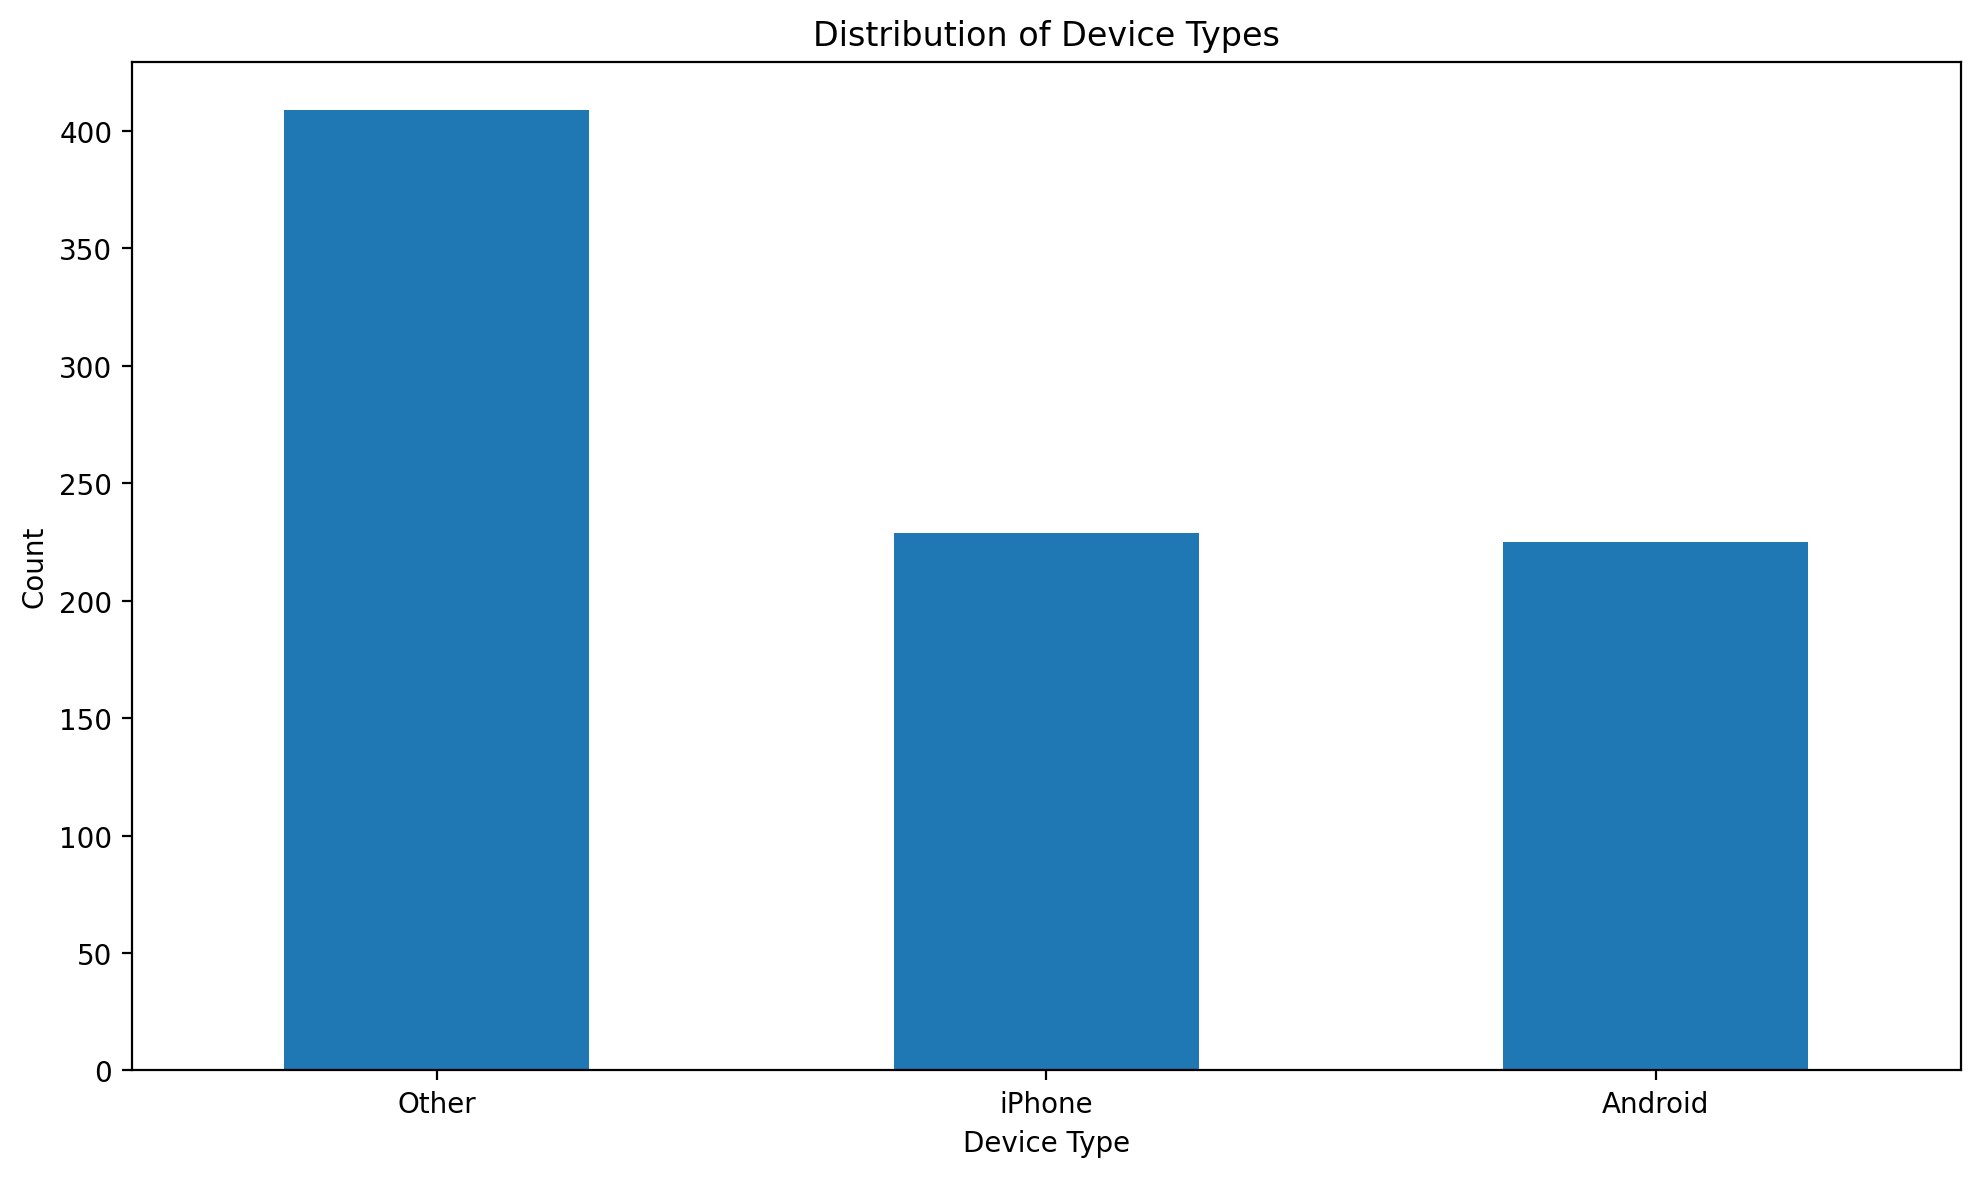

In [9]:
# Create a coarse classifier in terms of iPhone vs. Android vs. other
# Create a coarse classifier for iPhone vs. Android vs. other
def classify_device(user_agent):
    user_agent = user_agent.lower()
    if 'iphone' in user_agent:
        return 'iPhone'
    elif 'android' in user_agent:
        return 'Android'
    else:
        return 'Other'

# Apply the classifier to the user_agent column
df['device_type'] = df['user_agent'].apply(classify_device)

# Display the distribution of device types
device_distribution = df['device_type'].value_counts()
print("Device Type Distribution:")
print(device_distribution)

# Calculate the percentage distribution
device_percentage = device_distribution / len(df) * 100
print("\nDevice Type Percentage:")
print(device_percentage)

# Optionally, visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
device_distribution.plot(kind='bar')
plt.title('Distribution of Device Types')
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [11]:
# Generate data for Android devices
for color1, color2, hue_range in color_pairs:
    show_threshold(df.query('device_type == "Android"'), hue_range, color1, color2, output_file)

# Generate data for iPhone devices
for color1, color2, hue_range in color_pairs:
    show_threshold(df.query('device_type == "iPhone"'), hue_range, color1, color2, output_file)
